In [1]:
# 2023 Gabriel J. Diaz @ RIT

import os
import sys
import numpy as np

import logging
import pickle
from tqdm import tqdm

import io
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pathlib import Path, PurePath

import sys
sys.path.append('../..')
from flow_source import *

logger = logging.getLogger(__name__)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [2]:
x = 50
plt.rcParams['figure.figsize'] = [640/x, 480 /x]

img_out_path = 'image_out/'

if os.path.exists(img_out_path) is False:
    os.mkdir(img_out_path)
    
video_target_path = r'D:\Github\retinal_flow_toolkit\sandbox\overlay_gaze\dash_cam_nvidia2_hsv_overlay.mp4'
#video_target_path = r'D:\Github\retinal_flow_toolkit\sandbox\overlay_gaze\linear_travel_nvidia2_hsv_overlay.mp4'
video = cv2.VideoCapture(video_target_path)

# number of frames in the video
length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
print( length )


509


bgr_image shape:  (480, 640, 3)
average saturation channel:  17.347483723958334
flow from pickle file keys:  dict_keys(['flow', 'magnitude', 'angle'])
flow shape (480, 640, 2)
39.875 255.0


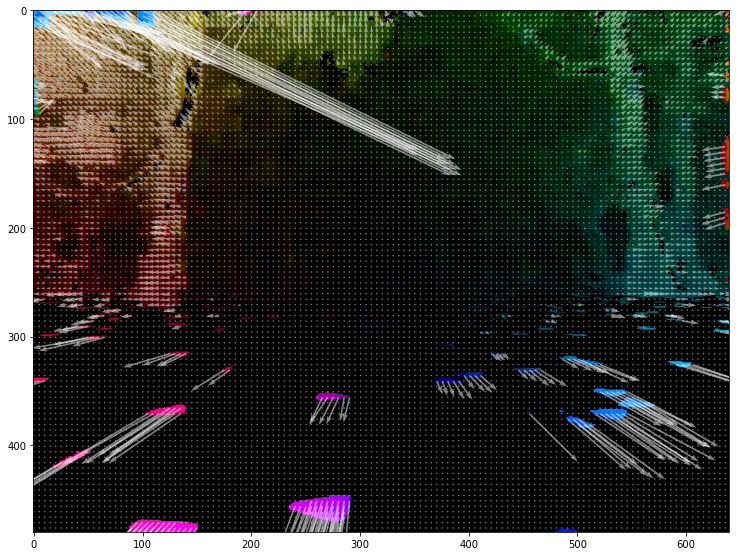

In [3]:
success = 1

f = 20
#14627 # rigth turn
video.set(cv2.CAP_PROP_POS_FRAMES, f)
success, bgr_image = video.read()
print('bgr_image shape: ', bgr_image.shape)
print('average saturation channel: ', np.mean(bgr_image[...,1]))

#x, y = cv2.polarToCart(hsv_image[...,2], hsv_image[...,0])
with open('pickleOut_2.pkl', 'rb') as f:
    flow_output = pickle.load(f)
print('flow from pickle file keys: ', flow_output.keys())
flow_pickle = flow_output['flow']
magnitude_pickle = flow_output['magnitude']
angle_pickle = flow_output['angle']
print('flow shape', flow_pickle.shape)

xmax=np.shape(bgr_image)[1]
xpoints = int(np.shape(bgr_image)[1])
x=np.linspace(0,np.shape(bgr_image)[1],xmax)

ymax=np.shape(bgr_image)[0]
ypoints = int(np.shape(bgr_image)[0])
y=np.linspace(0,np.shape(bgr_image)[0],ymax)
x2d,y2d=np.meshgrid(x,y,indexing='xy')

u = flow_pickle[...,0] *-1 * magnitude_pickle
v = flow_pickle[...,1] * magnitude_pickle
print(np.max(flow_pickle), np.max(magnitude_pickle))

skippts=5
skip=(slice(None,None,skippts),slice(None,None,skippts)) #don't plot all the point as this get too messy

plt.figure()
plt.imshow(cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB))
plt.quiver(x2d[skip], y2d[skip],u[skip],v[skip],color='white',alpha=0.5)

### Polar histogram of hue counts 

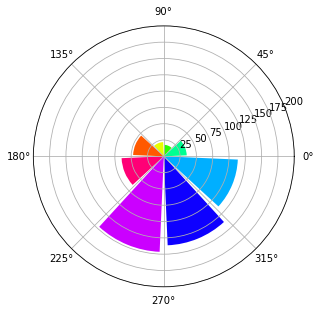

In [4]:
from matplotlib import cm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from collections import deque

bin_rad_hist = deque(maxlen=30)
width = 640
height = 480

dpi = 100
fig, ax = plt.subplots(figsize=(width/dpi, height/dpi), subplot_kw=dict(projection='polar'))
canvas = FigureCanvas(fig)
ax.margins(0)

ax.set_ylim([0, 200])

hist_params = (4 *2, 0, 360)
bins = np.linspace(hist_params[1], hist_params[2], hist_params[0] + 1)
bin_centers = [(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)]

cvals = np.array(bin_centers)/359+0.5
cvals[cvals > 1] = cvals[cvals > 1] - 1
hsv_map = cm.get_cmap('hsv').reversed()
bar_colors = hsv_map(cvals)

h = bgr_image[..., 0]
v = bgr_image[..., 2]

mag_flat = v.flatten()[v.flatten() > .1]
hue_flat = h.flatten()[v.flatten() > .1]

hue_flat = hue_flat * 2.0

bin_rad = []
for b_idx in range(1, len(bins)):
    idx = np.where(np.logical_and(hue_flat >= bins[b_idx - 1], hue_flat <= bins[b_idx]))
    bin_rad.append(np.mean(mag_flat[idx]))

bin_rad = np.nan_to_num(bin_rad)
# bin_rad_hist.appendleft(bin_rad)

ax.bar(np.deg2rad(bin_centers), bin_rad, width=2 * (np.pi / (len(bins))), color=bar_colors);

# plt.show
# canvas.draw()  # draw the canvas, cache the renderer
# image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
# image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))



In [5]:
def show_image_bgr(bgr_image):#, flow):
    # crops off the bad OF estimation from the outer parts of the image
    
    h = np.shape(bgr_image)[0]
    w = np.shape(bgr_image)[1]

    # width of analysis window in proportions of image width/height
    win_size = 0.8

    b = int(h/2 + (win_size*h)/2)
    t = int(h/2 - (win_size*h)/2)
    l = int(w/2 - (win_size*w)/2)
    r = int(w/2 + (win_size*w)/2)

    sm_image = bgr_image[t:b,l:r,:]
    #flow_crop = flow[t:b,l:r,:]
    #plt.imshow(cv2.cvtColor(sm_image, cv2.COLOR_BGR2RGB))

    #h = sm_image[..., 0]
    #v = sm_image[..., 2]

    #mag_flat = v.flatten()[v.flatten() > .1]
    #hue_flat = h.flatten()[v.flatten() > .1]

    #uidx = int(len(np.unique(mag_flat))/2)
    #val = np.unique(mag_flat)[uidx]

    #idx = np.where(mag_flat == uidx)[0][0]
    #print( f'Value - {mag_flat[idx]} Hue - {hue_flat[idx]}')

    return sm_image

sm_image = show_image_bgr(bgr_image)

https://notebook.community/joverbee/electromagnetism_course/vector_example

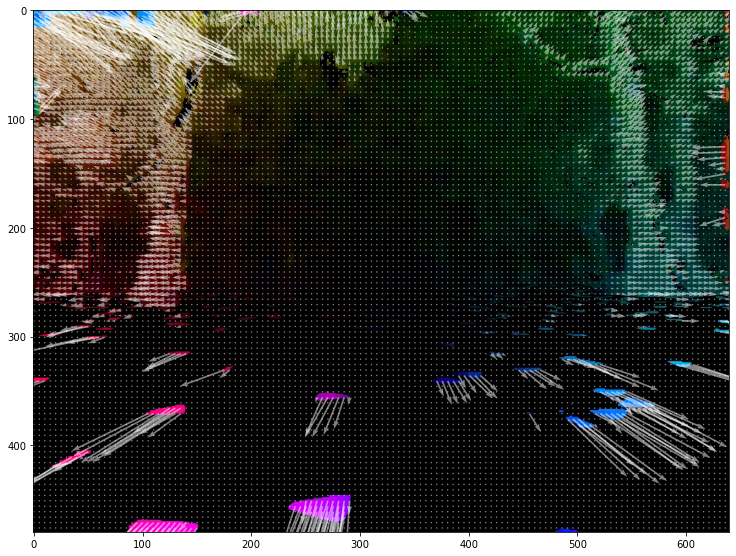

In [6]:
# IMPORTANT!!! You can't crop the image before running this function or it won't plot right. Do OF calculations first
def show_OF_on_rgb_img(image, frame_num, save=False):
    # rescale from 0-255 to 0-upper mag threshold (15)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    #mag = 15 * (hsv[..., 2] / 255.0)
    mag = hsv[...,2]
    
    h = hsv[..., 0]    
    # h = (angle * 180) / (2*np.pi) 
    
    angle = (hsv[..., 0] * np.pi * 2.0) / 180.0 # angles are in radians here

    xmax=np.shape(image)[1]
    xpoints = int(np.shape(image)[1])
    x=np.linspace(0,np.shape(image)[1],xmax)

    ymax=np.shape(image)[0]
    ypoints = int(np.shape(image)[0])
    y=np.linspace(0,np.shape(image)[0],ymax)

    x2d,y2d=np.meshgrid(x,y,indexing='xy')

    u = mag * np.cos(angle) * mag * -1 # this is the same as flow[...,0] * mag * -1, as I did above
    v = mag  * np.sin(angle) * mag

    skippts=5
    skip=(slice(None,None,skippts),slice(None,None,skippts)) #don't plot all the point as this get too messy
    
    plt.figure()
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.quiver(x2d[skip], y2d[skip],u[skip],v[skip],color='white',alpha=0.5)
    
    if save:
        plt.savefig(r'image_out\OF_quiver_plot_frame' + str(frame_num) + '.png')
        return
    else:
        img_buf = io.BytesIO()
        plt.savefig(img_buf, format='png')
        return img_buf
    #plt.show()

    
img = show_OF_on_rgb_img(bgr_image, f)

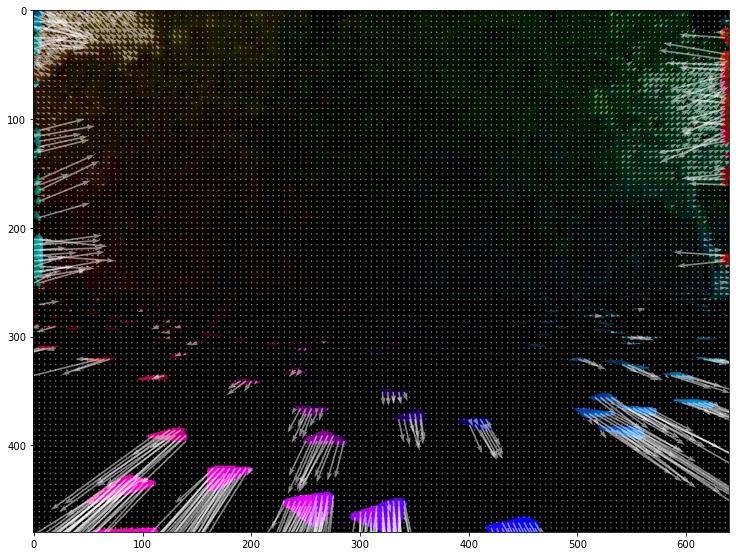

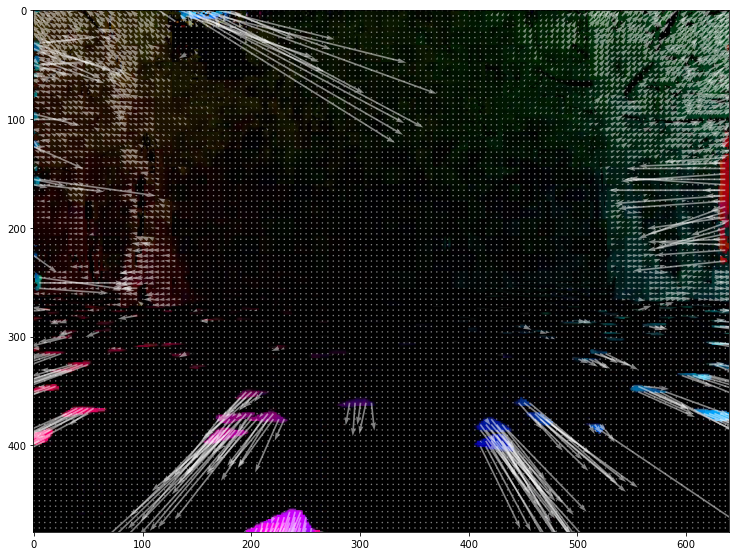

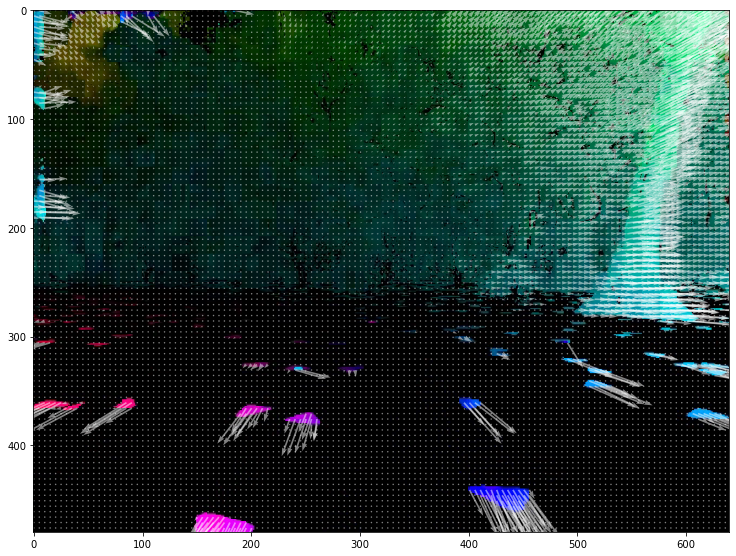

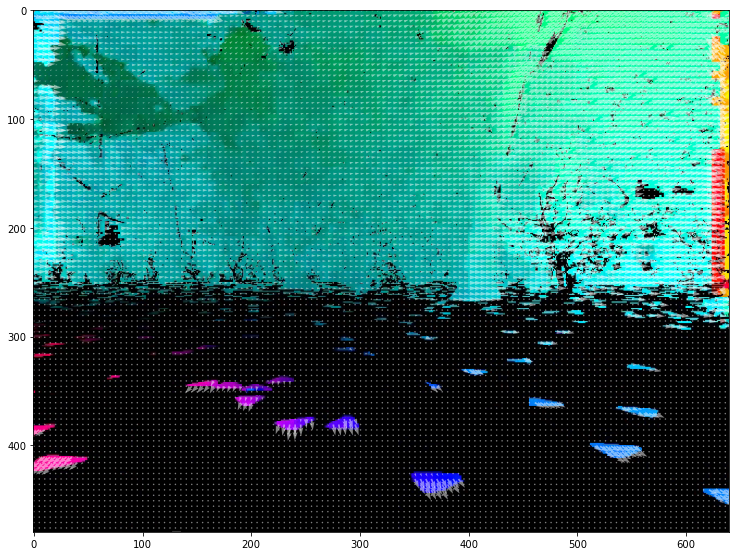

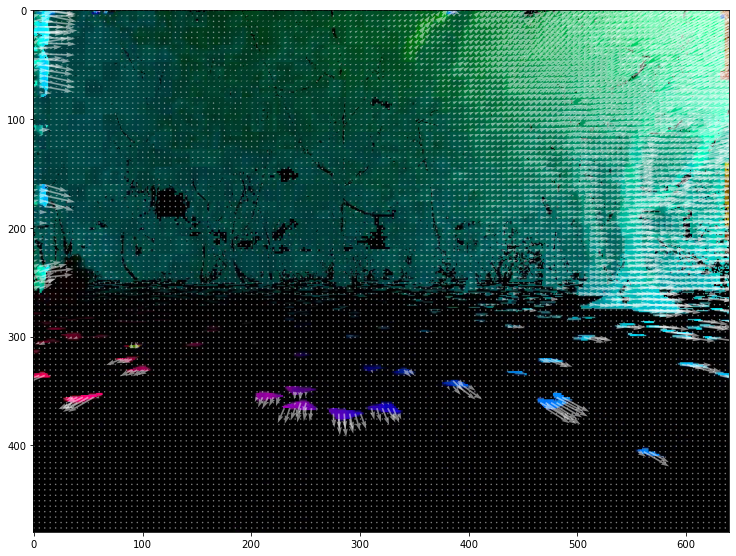

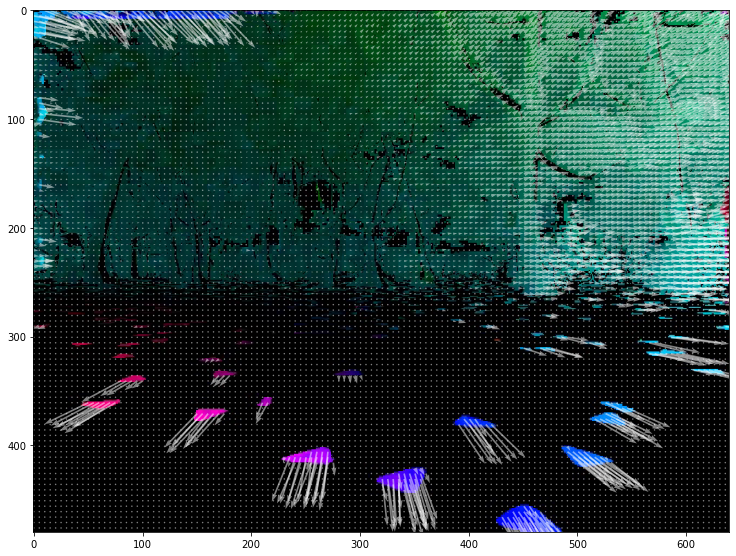

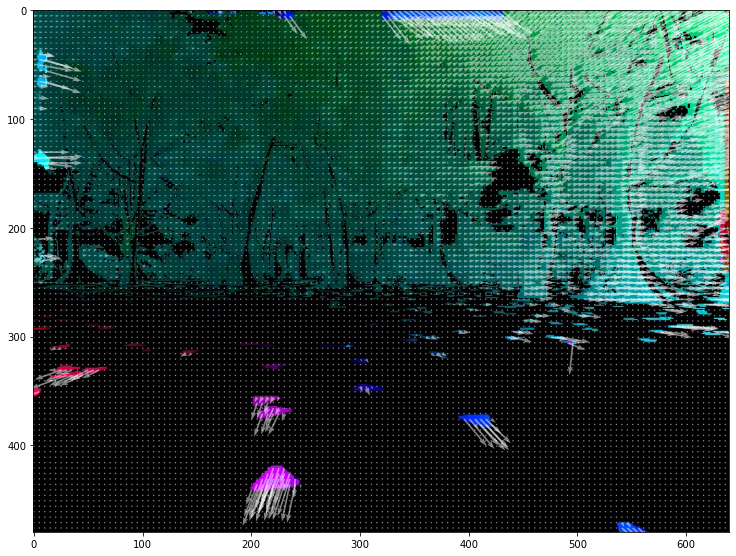

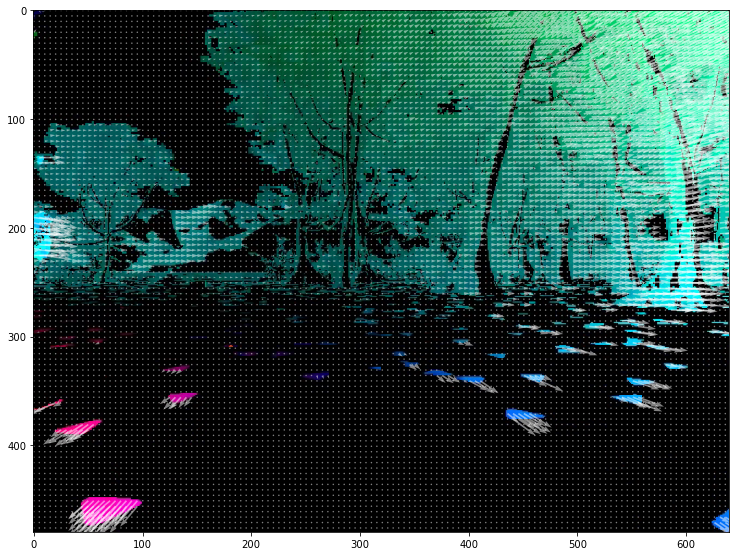

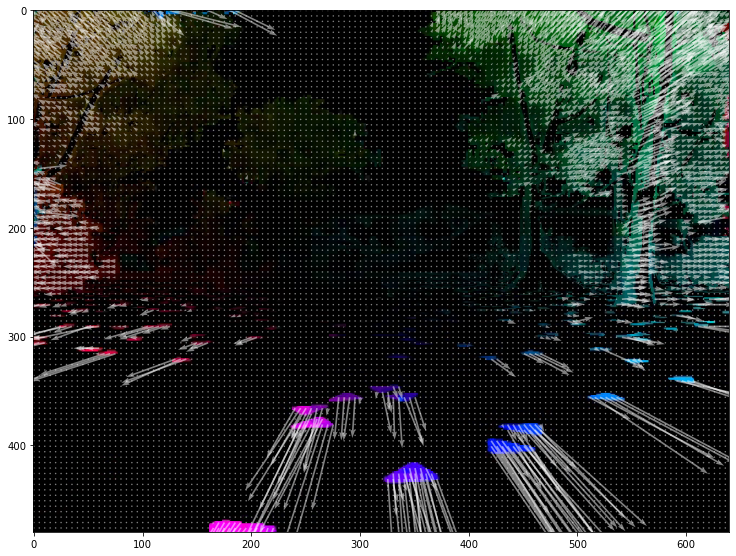

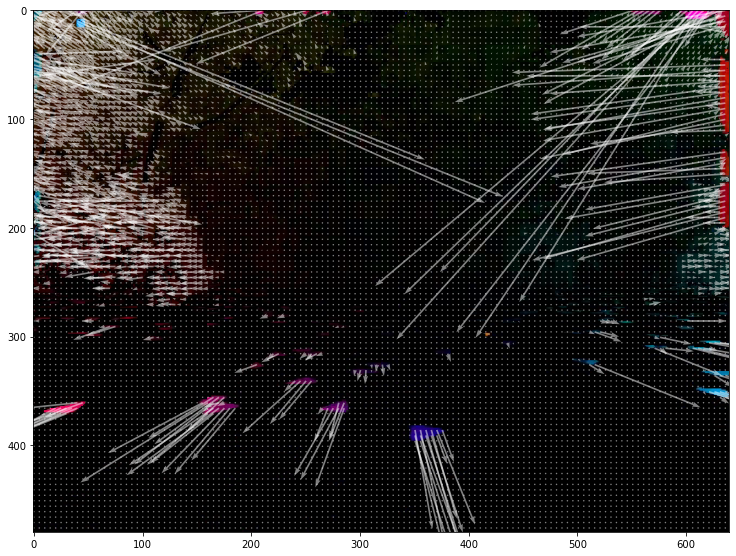

In [7]:
# print out multiple flow images
for f in np.arange(50,length,50):
    video.set(cv2.CAP_PROP_POS_FRAMES, f)
    __, bgr_image = video.read()
    #sm_image = show_image_bgr(bgr_image)
    img = show_OF_on_rgb_img(bgr_image, f, save=False)
    im = Image.open(img)

In [8]:
# play video through whole video

def play_video_with_superimposed_OF():

    for f in np.arange(0,length):

        video.set(cv2.CAP_PROP_POS_FRAMES, f)
        __, bgr_image = video.read()
        #sm_image = show_image_hsv(hsv_image)
        img = show_OF_on_rgb_img(bgr_image, f, save=False)
        im = Image.open(img)

        #hsv_image = cv2.putText(hsv_image, f'AZ: {g_az:.1f} EL: {g_el:.1f}', 
                                #(10, 50), cv2.FONT_HERSHEY_SIMPLEX, .6, 
                                #(255, 255, 255), 2, cv2.LINE_AA)

        cv2.imshow("test", np.asarray(im))
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
    
    cv2.destroyAllWindows()

In [9]:
#play_video_with_superimposed_OF()

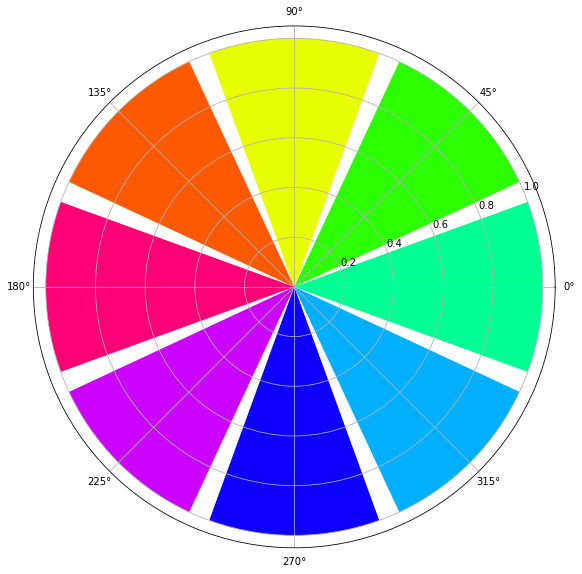

In [10]:
from matplotlib import cm
hsv_map = cm.get_cmap('hsv').reversed()

bin_centers = [(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)]
cvals = np.array(bin_centers)/359+0.5
cvals[cvals>1] = cvals[cvals>1]-1
colors = hsv_map(cvals)

counts = np.ones(len(bins)-1)
ax = plt.subplot(111, polar=True)

bars = ax.bar(np.deg2rad(bins[:-1]), counts, width=2*(np.pi / (len(bins))), color=colors)

# ax.set_ylim(.002)
plt.show()

In [11]:
# def divergence_npgrad(flow):
#     flow = np.swapaxes(flow, 0, 1)
#     Fx, Fy = flow[:, :, 0], flow[:, :, 1]
#     dFx_dx = np.gradient(Fx, axis=0)
#     dFy_dy = np.gradient(Fy, axis=1)
#     return dFx_dx + dFy_dy

# def curl_npgrad(flow):
#     flow = np.swapaxes(flow, 0, 1)
#     Fx, Fy = flow[:, :, 0], flow[:, :, 1]
#     dFx_dy = np.gradient(Fx, axis=1)
#     dFy_dx = np.gradient(Fy, axis=0)
#     curl = dFy_dx - dFx_dy
#     return curl